In [1]:
from helper_fns import *

In [2]:
mu_X1 = 70
sigma_X1 = 20
mu_X2 = 40
sigma_X2 = 10
sigma_eps = 5

In [3]:
np.random.seed(1996)

In [4]:
def f(x, y):
    return x*np.abs(np.log(np.abs(y/100))) + y*np.abs(np.log(np.abs(x/100)))

In [5]:
x = np.linspace(-10, 150, 50)
y = np.linspace(-10, 100, 50)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

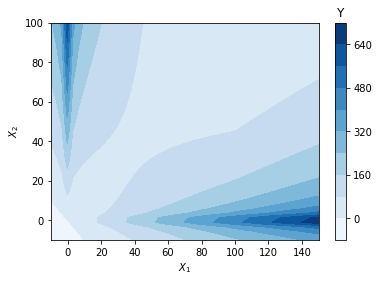

In [6]:
plt.contourf(X, Y, Z, 10, cmap = 'Blues')
ax = plt.subplot()
clb = plt.colorbar()
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
clb.ax.set_title('Y')
plt.savefig('simulated/simulated_data_contour.png')

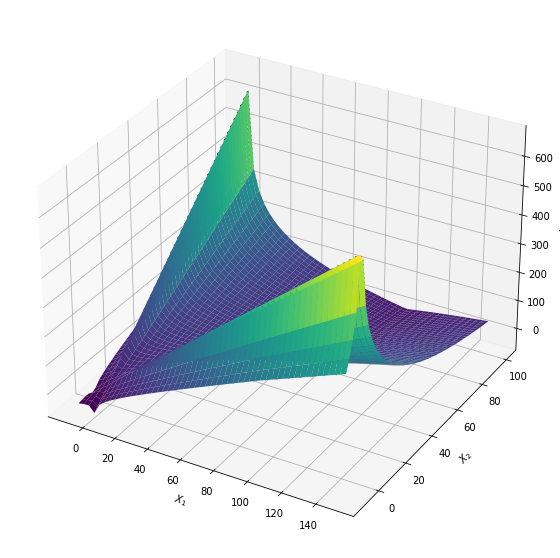

In [7]:
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection = '3d')
ax.contour3D(X, Y, Z, 50, cmap = 'binary')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_zlabel('Y');


ax.plot_surface(X, Y, Z, 
                rstride = 1, 
                cstride = 1,
                cmap = 'viridis',
                edgecolor = 'none')
plt.savefig('simulated/simulated_data.png')

### Simulate data 

In [8]:
dataset_to_use = 'simulated'

In [9]:
sample_n = 1000
n_total = sample_n
n_train = int(0.7*sample_n)
n_test = sample_n - n_train

In [10]:
#Simulate data
X1_sample = np.random.normal(loc = mu_X1, scale = sigma_X1, size = sample_n)
X2_sample = np.random.normal(loc = mu_X2, scale = sigma_X2, size = sample_n)
eps_sample = np.random.normal(loc = 0, scale = sigma_eps, size = sample_n)

## Why this choice of Y_true
Y_true = X1_sample*np.abs(np.log(np.abs(X2_sample/100))) + X2_sample*np.abs(np.log(np.abs(X1_sample/100))) + eps_sample

simulated_data = pd.DataFrame([X1_sample, X2_sample, Y_true]).T.rename(columns = {0:'X1', 1:'X2', 2: 'Y'})

X_simulated = simulated_data.iloc[:, 0:2].values
Y_simulated = simulated_data.iloc[:, 2].values

In [11]:
simulated_data.describe()

,X1,X2,Y
count,1000.000000,1000.000000,1000.000000
mean,69.346773,39.854362,83.344882
std,20.310310,10.042704,19.027718
min,5.199757,8.790692,40.328815
25%,55.962947,32.532160,70.980782
50%,69.454735,39.873977,79.212032
75%,82.928970,47.250531,92.590026
max,138.373947,73.681130,185.442010


In [12]:
simulated_data.to_csv('0.Datasets/simulated/simulated_data.csv',index=False)

### Fit models

In [13]:
X_train, Y_train, X_test, Y_test = generate_data_for_trials(1, n_train, n_total, X_simulated, Y_simulated)

In [14]:
X_train = X_train[0]
Y_train = Y_train[0]
X_test = X_test[0]
Y_test = Y_test[0]

In [15]:
# clf = RandomForestRegressor() 

# param_grid = {'n_estimators': [100, 200, 250, 500, 750, 1000],
#                  'max_depth': [2, 3, 4, 5, 6, 7, 10, 15]
#              }

# # 10-Fold Cross validation
# grid_clf = GridSearchCV(clf, param_grid, cv=10)
# grid_clf.fit(X_train, Y_train, verbose = 1)

# grid_clf.best_params_
# #{'max_depth': 7, 'n_estimators': 250}

In [16]:
# import optuna
# import tensorflow as tf

# # 1. Define an objective function to be maximized.
# def objective(trial):

#     # 2. Suggest values of the hyperparameters using a trial object.
#     n_layers = trial.suggest_int('n_layers', 1, 4)
#     early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, \
#                                    min_delta=0.001, restore_best_weights=True)
#     lr = trial.suggest_float('lr', 1e-5, 1e-1, log = True)
#     opt = tf.keras.optimizers.Adam(learning_rate = lr)
    
#     model = tf.keras.Sequential()
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log = True)
#         model.add(tf.keras.layers.Dense(num_hidden, activation ='relu'))
#     model.add(tf.keras.layers.Dense(1))
    
#     model.compile(optimizer = opt, loss = 'mse')
    
#     # fit model
#     model.fit(X_train, 
#               Y_train, 
#               validation_split = 0.25,
#               callbacks = [early_stopping],
#               epochs = 2000, 
#               verbose = 0)
    
#     mse = mean_squared_error(Y_test, model.predict(X_test))
    
#     return mse

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction = 'minimize')
# study.optimize(objective, n_trials = 30)

### Obtain prediction results

In [17]:
models = ['Mean', 'Linear Regression', 'SVR', 'KNN', 'Random forest', 'Polynomial Regression', 'MLP']
predictions_by_model = [naive(X_train, Y_train, X_test),
                        linear_regression(X_train, Y_train, X_test),
                        support_vector(X_train, Y_train, X_test),
                        knn(X_train, Y_train, X_test),
                        random_forest(X_train, Y_train, X_test),
                        polynomial_regression(X_train, Y_train, X_test),
                        neural_network(X_train, Y_train, X_test),
                       ]

10/10 [==============================] - 0s 436us/step


In [18]:
rmse = []
mae = []
rsquare = []

for i in range(len(models)):
    y_pred = predictions_by_model[i]
    
    rmse.append(np.round(math.sqrt(mean_squared_error(y_pred, Y_test)),decimals = 2))
    mae.append(np.round(mean_absolute_error(y_pred, Y_test),decimals = 2))
    rsquare.append(np.round(r2_score(y_pred, Y_test),decimals = 2))

model_stats = pd.DataFrame([models, rmse, mae, rsquare]).T.rename(columns = {0: "Model", 1: "RMSE", 2: "MAE", 3: "R2"}).set_index("Model")

In [19]:
model_stats[1:]

,RMSE,MAE,R2
Model,,,
Linear Regression,10.53,7.46,0.46
SVR,9.23,6.49,0.62
KNN,6.46,5.05,0.82
Random forest,6.41,4.85,0.83
Polynomial Regression,5.37,4.42,0.89
MLP,5.39,4.48,0.89


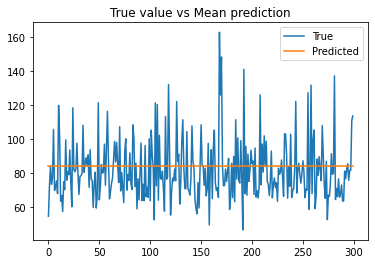

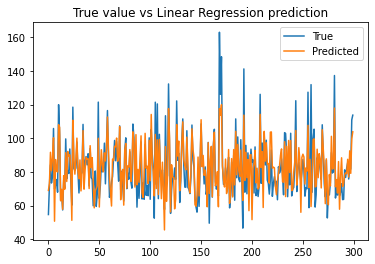

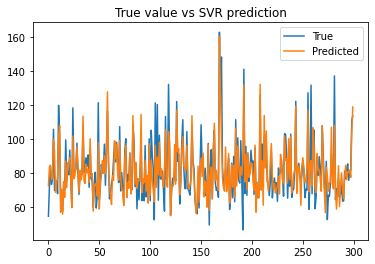

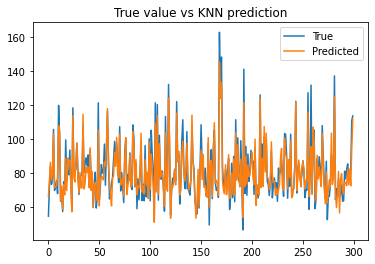

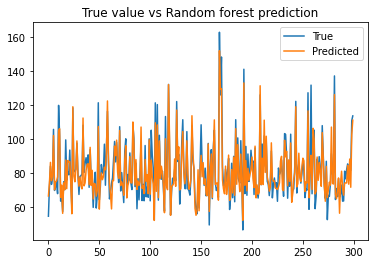

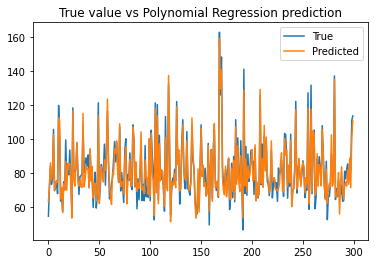

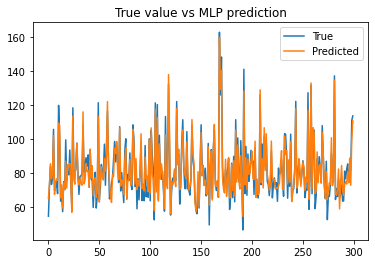

In [20]:
for i in range(len(models)):
    f = plt.figure()
    plt.plot(range(n_total - n_train),Y_test)
    plt.plot(range(n_total - n_train), predictions_by_model[i])
    plt.legend(['True', 'Predicted'])
    plt.title('True value vs '+ models[i] + ' prediction')